# Kaggle Project #1 - Bike Sharing Demand
* Source: https://www.kaggle.com/c/bike-sharing-demand

### Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

### The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## Dataset
* datetime - hourly date + timestamp
* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals
## Evaluation metrics
$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$
* n is the number of hours in the test set
* pi is your predicted count
* ai is the actual count
* log(x) is the natural logarithm

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
test_df=pd.read_csv('./data/bike/test.csv', parse_dates=['datetime'])
train_df=pd.read_csv('./data/bike/train.csv', parse_dates=['datetime'])
train_df.shape, test_df.shape

((10886, 12), (6493, 9))

In [3]:
all_df=pd.concat((train_df, test_df), axis=0).reset_index()
all_df

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [4]:
all_df.tail()

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN
17378,6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN


In [5]:
train_index=list(range(len(train_df)))
test_index=list(range(len(train_df),len(all_df)))

In [6]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       17379 non-null  int64         
 1   datetime    17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   holiday     17379 non-null  int64         
 4   workingday  17379 non-null  int64         
 5   weather     17379 non-null  int64         
 6   temp        17379 non-null  float64       
 7   atemp       17379 non-null  float64       
 8   humidity    17379 non-null  int64         
 9   windspeed   17379 non-null  float64       
 10  casual      10886 non-null  float64       
 11  registered  10886 non-null  float64       
 12  count       10886 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 1.7 MB


In [7]:
all_df.isnull().sum()

index            0
datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

### Evaluation metrics
$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

In [8]:
# nan_to_num nan 값에 아주 작은 값을 넣어줌 음수가 나오지 않게 하기 위해.
def rmsle(y,y_):
    log1=np.nan_to_num(np.log(y+1))
    log2=np.nan_to_num(np.log(y_+1))
    calc=(log1-log2)**2
    return np.sqrt(np.mean(calc))

In [9]:
submission_df=pd.read_csv('./data/bike/sampleSubmission.csv')
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [10]:
rmsle(submission_df['count'].values, np.random.randint(0,100, size=len(submission_df)))

3.746757494523852

In [11]:
all_df=all_df.drop(all_df[['casual','registered','index']],axis=1)

In [12]:
all_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN


In [13]:
pre_df=all_df.merge(pd.get_dummies(all_df['season'], prefix='season'), left_index=True, right_index=True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,1,0,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,1,0,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,1,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,1,0,0,0


In [14]:
pre_df=pre_df.merge(pd.get_dummies(all_df['weather'], prefix='weather'), left_index=True, right_index=True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0,1,0,0,0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0,1,0,0,0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0,1,0,0,0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0,1,0,0,0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,1,0,0,0,0,1,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,1,0,0,0,0,1,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,1,0,0,0,1,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,1,0,0,0,1,0,0,0


In [15]:
pre_df['datetime'].unique()

array(['2011-01-01T00:00:00.000000000', '2011-01-01T01:00:00.000000000',
       '2011-01-01T02:00:00.000000000', ...,
       '2012-12-31T21:00:00.000000000', '2012-12-31T22:00:00.000000000',
       '2012-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
pre_df['year']=pre_df['datetime'].dt.year
pre_df['month']=pre_df['datetime'].dt.month
pre_df['day']=pre_df['datetime'].dt.day
pre_df['hour']=pre_df['datetime'].dt.hour
pre_df['weekday']=pre_df['datetime'].dt.weekday

In [17]:
pre_df=pre_df.merge(pd.get_dummies(pre_df['weekday'],prefix='weekday'),left_index=True,right_index=True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,...,day,hour,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0,...,1,0,5,0,0,0,0,0,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0,...,1,1,5,0,0,0,0,0,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0,...,1,2,5,0,0,0,0,0,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0,...,1,3,5,0,0,0,0,0,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0,...,1,4,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,31,19,0,1,0,0,0,0,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,31,20,0,1,0,0,0,0,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,...,31,21,0,1,0,0,0,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,...,31,22,0,1,0,0,0,0,0,0


In [18]:
pre_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                float64
season_1               uint8
season_2               uint8
season_3               uint8
season_4               uint8
weather_1              uint8
weather_2              uint8
weather_3              uint8
weather_4              uint8
year                   int64
month                  int64
day                    int64
hour                   int64
weekday                int64
weekday_0              uint8
weekday_1              uint8
weekday_2              uint8
weekday_3              uint8
weekday_4              uint8
weekday_5              uint8
weekday_6              uint8
dtype: object

In [19]:
category_variable_list = ["season","weather","workingday","season_1","season_2","season_3","season_4","weather_1","weather_2","weather_3","weather_4","year","month","day","hour","weekday","weekday_0","weekday_1","weekday_2","weekday_3","weekday_4","weekday_5","weekday_6"]
for var_name in category_variable_list:
    pre_df[var_name] = pre_df[var_name].astype("category")

In [20]:
pre_df.dtypes

datetime      datetime64[ns]
season              category
holiday                int64
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                float64
season_1            category
season_2            category
season_3            category
season_4            category
weather_1           category
weather_2           category
weather_3           category
weather_4           category
year                category
month               category
day                 category
hour                category
weekday             category
weekday_0           category
weekday_1           category
weekday_2           category
weekday_3           category
weekday_4           category
weekday_5           category
weekday_6           category
dtype: object

In [21]:
train_df=pre_df.iloc[train_index]
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,...,day,hour,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0,...,1,0,5,0,0,0,0,0,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40.0,...,1,1,5,0,0,0,0,0,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32.0,...,1,2,5,0,0,0,0,0,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13.0,...,1,3,5,0,0,0,0,0,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0,...,1,4,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336.0,...,19,19,2,0,0,1,0,0,0,0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241.0,...,19,20,2,0,0,1,0,0,0,0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168.0,...,19,21,2,0,0,1,0,0,0,0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129.0,...,19,22,2,0,0,1,0,0,0,0


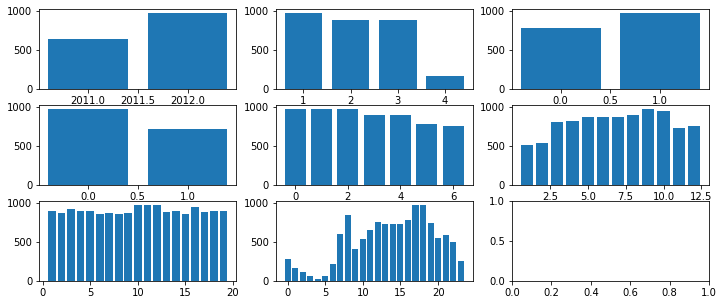

In [22]:
# count과 feature들간의 상관관계 시각화
fig, axes = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches(12, 5)
axes[0][0].bar(train_df["year"], train_df["count"])
axes[0][1].bar(train_df["weather"], train_df["count"])
axes[0][2].bar(train_df["workingday"], train_df["count"])
axes[1][0].bar(train_df["holiday"], train_df["count"])
axes[1][1].bar(train_df["weekday"], train_df["count"])
axes[1][2].bar(train_df["month"], train_df["count"])
axes[2][0].bar(train_df["day"], train_df["count"])
axes[2][1].bar(train_df["hour"], train_df["count"])
plt.show()

In [23]:
series_data=train_df.groupby(['year','month'])['count'].mean()
series_data.index.tolist()

[(2011, 1),
 (2011, 2),
 (2011, 3),
 (2011, 4),
 (2011, 5),
 (2011, 6),
 (2011, 7),
 (2011, 8),
 (2011, 9),
 (2011, 10),
 (2011, 11),
 (2011, 12),
 (2012, 1),
 (2012, 2),
 (2012, 3),
 (2012, 4),
 (2012, 5),
 (2012, 6),
 (2012, 7),
 (2012, 8),
 (2012, 9),
 (2012, 10),
 (2012, 11),
 (2012, 12)]

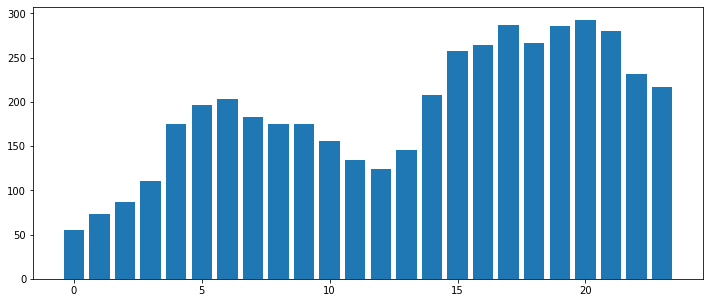

In [24]:
fig, ax=plt.subplots()
ax.bar(range(len(series_data)), series_data)
fig.set_size_inches(12,5)
plt.show()

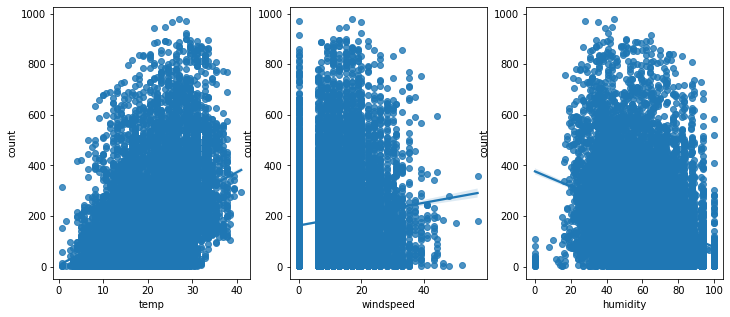

In [25]:
# 두 번째 그림보면 데이터가 이상한듯함. 이런 것은 직접 확인
import seaborn as sn

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=train_df,ax=ax1)
sn.regplot(x="windspeed", y="count", data=train_df,ax=ax2)
sn.regplot(x="humidity", y="count", data=train_df,ax=ax3)
plt.show()

In [26]:
category_variable_list

['season',
 'weather',
 'workingday',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'year',
 'month',
 'day',
 'hour',
 'weekday',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

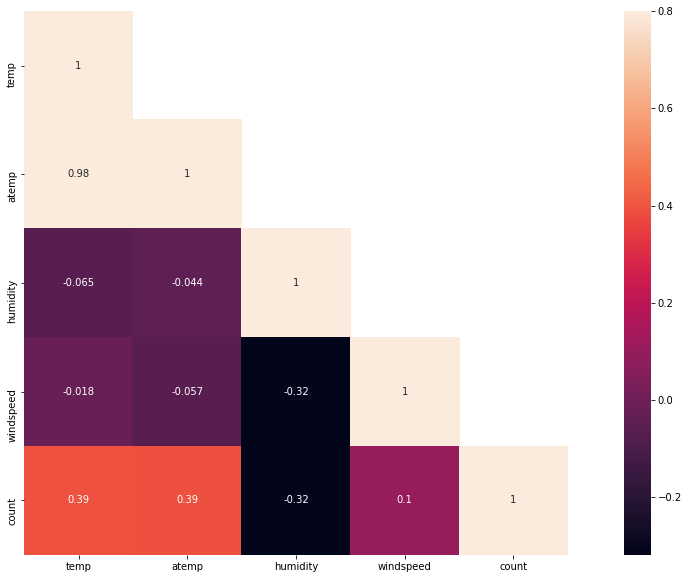

In [27]:
corrMatt = train_df[["temp","atemp","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

In [28]:
continuous_variable_list = ["temp","humidity","windspeed","atemp"]

In [29]:
season_list = ['season_1', 'season_2', 'season_3', 'season_4']
weather_list = ['weather_1', 'weather_2', 'weather_3', 'weather_4']
weekday_list = ['weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6']

In [30]:
category_varialbe_list = ["season","holiday","workingday","weather","weekday","month","year","hour"]

In [31]:
all_variable_list = continuous_variable_list + category_varialbe_list

In [32]:
all_variable_list.append(season_list)
all_variable_list.append(weather_list)
all_variable_list.append(weekday_list)

In [33]:
all_variable_list

['temp',
 'humidity',
 'windspeed',
 'atemp',
 'season',
 'holiday',
 'workingday',
 'weather',
 'weekday',
 'month',
 'year',
 'hour',
 ['season_1', 'season_2', 'season_3', 'season_4'],
 ['weather_1', 'weather_2', 'weather_3', 'weather_4'],
 ['weekday_0',
  'weekday_1',
  'weekday_2',
  'weekday_3',
  'weekday_4',
  'weekday_5',
  'weekday_6']]

In [34]:
number_of_variables = len(all_variable_list)
number_of_variables

15

In [35]:
varaible_combinations = []
import itertools
for L in range(8, number_of_variables+1):
    for subset in itertools.combinations(all_variable_list, L):
        temp = []
        for variable in subset:
            if isinstance(variable, list):
                for value in variable:
                    temp.append(value)
            else:
                temp.append(variable)
        varaible_combinations.append(temp)

In [51]:
len(varaible_combinations)

16384

In [52]:
del pre_df["count"]

In [55]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import datetime

kf= KFold(n_splits=10)

y = train_df["count"].values
final_output = []
models = []

print(len(varaible_combinations))
ts = datetime.datetime.now()
for i, combination in enumerate(varaible_combinations):
    lr = LinearRegression(n_jobs=8)
    ridge = Ridge()
    lasso = Lasso()
    
    lr_result = []
    ridge_result = []
    lasso_result = []
    
    target_df = pre_df[combination]
    ALL = target_df.values
    std = StandardScaler()
    std.fit(ALL)
    ALL_scaled = std.transform(ALL)
    X = ALL_scaled[train_index]
    
    for train_data_index, test_data_index in kf.split(X):
        X_train = X[train_data_index]
        X_test = X[test_data_index]
        y_train = y[train_data_index]
        y_test = y[test_data_index]
        
        lr.fit(X_train, y_train)
        result = rmsle(y_test, lr.predict(X_test))
        lr_result.append(result)

        ridge.fit(X_train, y_train)
        result = rmsle(y_test, ridge.predict(X_test))
        ridge_result.append(result)

        lasso.fit(X_train, y_train)
        result = rmsle(y_test, lasso.predict(X_test))
        lasso_result.append(result)
    
    final_output.append([i, np.mean(lr_result), np.mean(ridge_result), np.mean(lasso_result)])
    models.append([lr, ridge, lasso])
    if i % 100 == 0:
        tf = datetime.datetime.now()
        te = tf - ts  
        print(i, te)
        ts = datetime.datetime.now()

16384
0 0:00:00.238295
100 0:00:28.891650
200 0:00:32.688307
300 0:00:33.980897
400 0:00:24.189650
500 0:00:20.845073
600 0:00:20.607934
700 0:00:19.838943
800 0:00:24.612563
900 0:00:30.866128
1000 0:00:36.181545
1100 0:00:33.415995
1200 0:00:38.263214
1300 0:00:31.260327
1400 0:00:23.261068
1500 0:00:27.426042
1600 0:00:21.658843
1700 2:01:05.769998
1800 0:00:37.515645
1900 0:00:42.855650
2000 0:01:00.142399
2100 0:01:06.349266
2200 0:01:03.942742
2300 0:00:53.208665
2400 0:00:51.475027
2500 0:00:47.872189
2600 0:00:52.029820
2700 0:00:49.186426
2800 0:00:52.185188
2900 0:00:54.891162
3000 0:00:53.320611
3100 0:00:57.858944
3200 0:00:49.744695
3300 0:00:55.408779
3400 0:00:51.031722
3500 0:00:33.969129
3600 0:00:32.451225
3700 0:00:32.354248
3800 0:00:31.207519
3900 0:00:35.177139
4000 0:00:45.993507
4100 0:00:55.612722
4200 0:00:54.755346
4300 0:01:03.547259
4400 0:00:57.225930
4500 0:00:35.257566
4600 0:00:40.470295
4700 0:00:32.541631
4800 0:00:36.972938
4900 0:00:49.419229
5000 0

KeyboardInterrupt: 

In [56]:
labels = ["combination", "lr","ridge", "lasso"]

from pandas import DataFrame
result_df = DataFrame(final_output, columns=labels)
result_df.head()

,combination,lr,ridge,lasso
0,0,1.453390,1.452092,1.439138
1,1,1.457821,1.456870,1.441897
2,2,1.465858,1.465260,1.455254
3,3,1.423371,1.423143,1.417983
4,4,1.306359,1.304990,1.288698


In [57]:
result_df.min()

combination    0.000000
lr             1.258927
ridge          1.258814
lasso          1.254718
dtype: float64

In [58]:
result_df["lasso"].sort_values().head()

4752    1.254718
4641    1.254737
4696    1.254737
4661    1.254758
3674    1.255428
Name: lasso, dtype: float64

In [59]:
varaible_combinations[4752]

['humidity',
 'atemp',
 'workingday',
 'weather',
 'weekday',
 'hour',
 'weather_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [60]:
target_df = pre_df[varaible_combinations[4752]]
ALL = target_df.values
std = StandardScaler()
std.fit(ALL)
ALL_scaled = std.transform(ALL)
X_submission_test = ALL_scaled[test_index]
X_submission_test.shape

(6493, 17)

In [61]:
X_submission_test

array([[-0.34847267, -1.44592342,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641],
       [-0.34847267, -1.18173227,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641],
       [-0.34847267, -1.18173227,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641],
       ...,
       [-0.14113744, -1.26960201,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641],
       [-0.34847267, -1.18173227,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641],
       [ 0.11803159, -1.18173227,  0.68170976, ..., -0.40865929,
        -0.41105331, -0.41009641]])

In [62]:
models[4752][2]

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
final_result = models[4752][2].predict(X_submission_test)
final_result[final_result < 0] = 0

In [64]:
final_result

array([ 13.872059  ,  38.74604771,  46.13213347, ..., 169.7221112 ,
       190.73140758, 180.55230694])

In [65]:
pre_df.iloc[test_index]["datetime"].head()


10886   2011-01-20 00:00:00
10887   2011-01-20 01:00:00
10888   2011-01-20 02:00:00
10889   2011-01-20 03:00:00
10890   2011-01-20 04:00:00
Name: datetime, dtype: datetime64[ns]

In [66]:
data = {"datetime": pre_df.iloc[test_index]["datetime"], "count": final_result}
df_submission = DataFrame(data, columns=["datetime", "count"])
df_submission.head()

,datetime,count
10886,2011-01-20 00:00:00,13.872059
10887,2011-01-20 01:00:00,38.746048
10888,2011-01-20 02:00:00,46.132133
10889,2011-01-20 03:00:00,47.701758
10890,2011-01-20 04:00:00,55.087844


In [67]:
df_submission.set_index("datetime").to_csv("submission_lasso_data.csv")
